In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from nonlocalgames import methods
from nonlocalgames.hamiltonians import G14

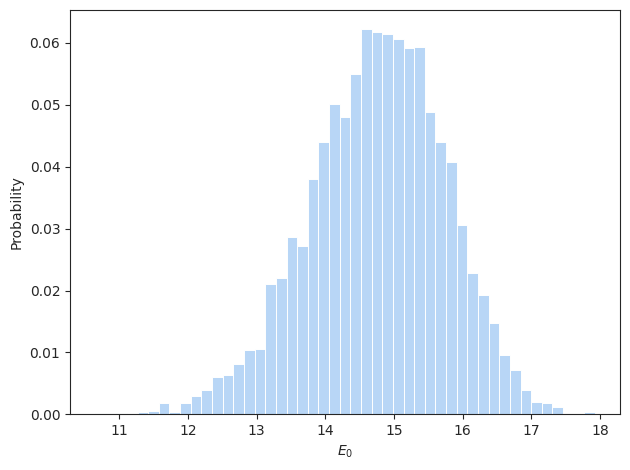

In [20]:
from numpy import linalg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

values = []
ham = G14(init_mode='normal')
for i in range(5000):
    ham.init(seed=i)
    w, _ = linalg.eigh(ham.mat)
    values.append(w.min())

sns.histplot(data=values, stat='probability')
plt.xlabel('$E_0$')
plt.tight_layout()
plt.savefig('plots/g14_random_init.png', dpi=300)

In [16]:
import json
import numpy as np
import gymnasium as gym
import logging
gym.logger.set_level(logging.CRITICAL)

best_energy = np.inf
best_energies = None
best_ansatz, best_phi = None, None

for i in range(50):
    ham = G14()
    energies, state, phi = methods.dual_phase_optim(ham, verbose=1, seed=i, tol=1e-6)
    energy = energies[-1]
    
    if energy < best_energy:
        best_energy = energy
        best_energies = energies
        state = [(theta, str(gate)) for theta, gate in state]
        best_ansatz = state
        best_phi = phi.reshape(2, 14, 2).tolist()

        with open('data/g14_state.json', 'w', encoding='utf-8') as f:
            json.dump({
                'state': best_ansatz,
                'phi': best_phi,
                'energies': best_energies
            }, f)

Iter 1
-----------
Energy: 0.6027545898902663

Iter 2
-----------
Energy: 0.585910893448423

Iter 3
-----------
Energy: 0.585787348287667

Iter 4
-----------
Energy: 0.5857864377980728

Iter 1
-----------
Energy: 0.36633939538939553

Iter 2
-----------
Energy: 0.24516081924199334

Iter 3
-----------
Energy: 0.24471898959816063

Iter 4
-----------
Energy: 0.24471741890639578

Iter 5
-----------
Energy: 0.24471741888321596

Iter 1
-----------
Energy: 0.9968560034157912

Iter 2
-----------
Energy: 0.5918112127820495

Iter 3
-----------
Energy: 0.5858736999433798

Iter 4
-----------
Energy: 0.585787109767723

Iter 5
-----------
Energy: 0.5857864376588113

Iter 1
-----------
Energy: 0.6004827753954618

Iter 2
-----------
Energy: 0.24568780266843931

Iter 3
-----------
Energy: 0.24471941675577366

Iter 4
-----------
Energy: 0.24471741882630105

Iter 5
-----------
Energy: 0.2447174187989934

Iter 1
-----------
Energy: 0.34037912758872496

Iter 2
-----------
Energy: 0.24487970492282018

Iter 3

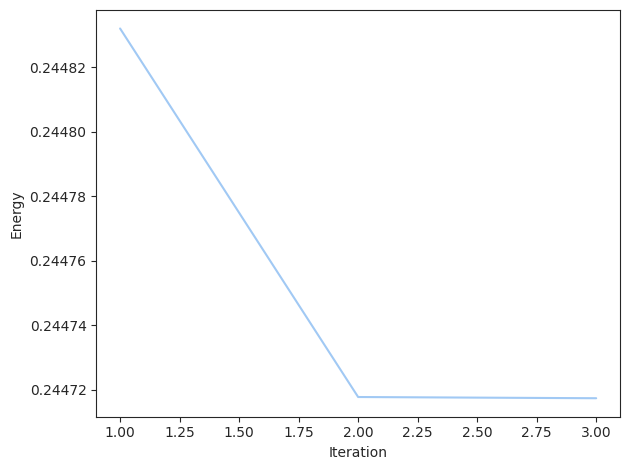

In [19]:
import pandas as pd

df = pd.DataFrame({
    'energy': best_energies,
    'iter': list(range(1, len(best_energies) + 1))
})

sns.lineplot(data=df, x='iter', y='energy')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.tight_layout()
plt.savefig('plots/g14_best_energy.png', dpi=300)